### Data for NN models

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def prepare_data_feat_step(prices, training_days, n_lags, step, target_col='MA', extra_features=['RSI']):
    """
    Prepares data for LSTM model considering a window of n_lags past observations to create X_train and X_test.
    y_train is prepared for long-term forecasting with a specified forecast horizon.

    Args:
        prices (pd.DataFrame): DataFrame containing the historical price data.
        training_days (int): Number of days to use for training.
        n_lags (int): Number of past observations to use as features.
        step (int): The day to forecast in future. If ==0 means that the next day will be predicted
        target_col (str): The target column to forecast.
        extra_features (list): List of additional features to include.

    Returns:
        tuple: (X_train, y_train, X_test, real_stock_price, sc_target) where:
            - X_train (np.ndarray): Training features.
            - y_train (np.ndarray): Training targets.
            - X_test (np.ndarray): Testing features.
            - real_stock_price (pd.DataFrame): Real stock prices for comparison.
            - sc_target (MinMaxScaler): Scaler used for the target column.
    """
    # Split prices into train and test
    dataset_train, dataset_test = prices.iloc[:training_days], prices.iloc[training_days:]
    cols = [target_col] + extra_features
    sc_extra = {}
    features_scaled = {}

    # Scale features
    for f in cols:
        sc_extra[f] = MinMaxScaler(feature_range=(0, 1))
        features_scaled[f] = sc_extra[f].fit_transform(dataset_train[[f]].values)

    # Create a data structure with n_lags timesteps and step output
    X_train = []
    y_train = []
    for i in range(n_lags, len(features_scaled[target_col]) - step):
        x_train = features_scaled[target_col][i - n_lags:i].squeeze()
        for f in extra_features:
            x_train = np.hstack((x_train, features_scaled[f][i - n_lags:i].squeeze()))
        X_train.append(x_train)
        #y_train.append(dataset_train[target_col].iloc[i + step])
        y_train.append(features_scaled[target_col][i + step])
    X_train, y_train = np.array(X_train), np.array(y_train)
    # Reshape for LSTM to include the new dimension
    X_train = np.reshape(X_train, (X_train.shape[0], n_lags, len(cols)))

    # Prepare test set
    real_stock_price = dataset_test[[target_col]]
    dataset_total = pd.concat((dataset_train[cols], dataset_test[cols]), axis=0)
    dataset_total = dataset_total[len(dataset_total) - len(dataset_test) - n_lags:]

    for f in cols:
        dataset_total[f] = sc_extra[f].transform(dataset_total[[f]])

    X_test = []
    for i in range(n_lags, len(dataset_total) - step):
        x_test = dataset_total[target_col][i - n_lags:i].values
        for f in extra_features:
            x_test = np.hstack((x_test, dataset_total[f][i - n_lags:i].values))
        X_test.append(x_test)
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], n_lags, len(cols)))

    return X_train, y_train, X_test, real_stock_price, sc_extra


In [3]:
stock_price=pd.read_csv('../data/TSLA.csv')

In [4]:
stock_price.index=pd.DatetimeIndex(stock_price['Unnamed: 0'])

In [5]:
training_days=int(len(stock_price)*0.75)
n_lags=5
step=0
target_col='Close'
extra_features=['Volume']
X_train, y_train, X_test, real_stock_price, sc_extra=prepare_data_feat_step(stock_price, training_days, n_lags, step, target_col, extra_features)


/opt/anaconda3/envs/finance/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/finance/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


#### Data for XGBoost model

In [14]:
X_train_df=pd.DataFrame(X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2]))
col_vals=[target_col]+extra_features
cols_res=[]
for c in col_vals:
    for i in range(1, n_lags+1,1):
        cols_res.append(f'{c}_{n_lags-i+1}')
X_train_df.columns=cols_res
train_ind=stock_price.iloc[n_lags:training_days].index

X_train_df.index=train_ind
y_train_df=pd.Series(y_train.squeeze(-1),index=train_ind)

X_test_df=pd.DataFrame(X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2]))
X_test_df.columns=cols_res

In [15]:
sc_extra[target_col]

{'Close': MinMaxScaler(), 'Volume': MinMaxScaler()}

### Data for Darts

In [49]:
from darts import TimeSeries

In [60]:
ts=stock_price.rename(columns={'Unnamed: 0':'date', target_col:'value'})
ts=ts[['date', 'value']]
ts['date']=pd.to_datetime(ts['date'])

In [64]:
# Create TimeSeries object with fill_missing_dates and specified frequency
series = TimeSeries.from_dataframe(ts, time_col='date', value_cols=['value'], fill_missing_dates=True, freq='B')  # 'B' stands for business day frequency


<Axes: xlabel='date'>

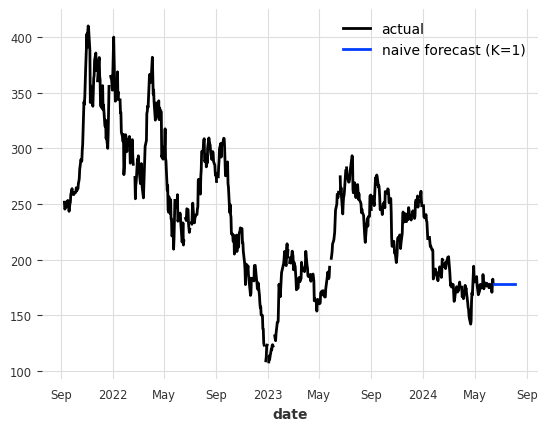

In [66]:
from darts.models import NaiveSeasonal

naive_model = NaiveSeasonal(K=1)
naive_model.fit(series)
naive_forecast = naive_model.predict(36)

series.plot(label="actual")
naive_forecast.plot(label="naive forecast (K=1)")

### Data for neuralforecast

Nuralforecast can be run on Python version <3.12
We'll create additional conda environment with Python 3.10 to run the Nuralforecast in a separate notebook